# Introduction

I developed a simple routine to insert zeros into a time series based on valid recorded power gap messages from the meter.
This allows a straightforward aggregation approach for getting daily energy use.

# Method

- perform zero insertion on energy data
- sum minute energy use over 24 hour periods

This method does not attempt to correct or account for

- periods with data loss (these will underreport)
- increments in kWh export during data loss
- days of complete or incomplete service

# Results

This allows for more complete records than previous analyses.

# Next Work

In [1]:
%load_ext autoreload

In [3]:
%autoreload 2
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import WP19_analysis as wpa
#import tabulate

def wpa_insert_power_gap_zeros(energy_data, messages):
    # this puts zeros in the recorded power gaps and leaves data gaps untouched
    power_down = messages[messages['message']=='Power Down'].index.values
    power_up = messages[messages['message']=='Power Up'].index.values
    # this is diffing all columns and possibly slowing down function
    diffed = energy_data[['kWh export']].resample('1T').asfreq().diff().shift(-1)
    for i in diffed.index.values:
        # if either boundary of the interval is in a power gap, we want to insert a zero
        # if the insertion point of the index is one greater for the power_down time, you are in a gap
        if np.searchsorted(power_down, i) == np.searchsorted(power_up, i) + 1:
            diffed.loc[i]['kWh export'] = 0
        end_interval = i + np.timedelta64(1,'m')
        if np.searchsorted(power_down, end_interval) == np.searchsorted(power_up, end_interval) + 1:
            diffed.loc[i]['kWh export'] = 0
    return diffed['kWh export']

In [4]:
resampled_data = {}
for rfd in wpa.raw_file_data:
    vname = rfd['village_name']
    print(vname)
    energy_data = wpa.load_timeseries_file(vname + '-clean.csv')
    messages = wpa.load_message_file(vname + '-messages.csv')
    diffed = wpa_insert_power_gap_zeros(energy_data, messages)
    #daily = diffed.groupby(diffed.index.date).sum()
    resampled_data[vname] = diffed

ajau


asei


atamali


ayapo


kensio


In [5]:
# write this out to disk
for rfd in wpa.raw_file_data:
    vname = rfd['village_name']
    diffed = resampled_data[vname]
    #diffed.to_csv(vname + '-resampled.csv')

In [6]:
# create a table of summary statistics
tmp_dict = {}
for rfd in wpa.raw_file_data:
    vname = rfd['village_name']
    diffed = resampled_data[vname]
    daily = diffed.groupby(diffed.index.date).sum()
    #print(vname, daily.mean(), daily.median())
    tmp_dict[vname] = {'mean kWh per day':daily.mean(),
                       'median kWh per day':daily.median(),
                       'max kWh per day':daily.max(),
                       'days observed':daily.count()}
daily_stats = pd.DataFrame(tmp_dict).T
daily_stats

,days observed,max kWh per day,mean kWh per day,median kWh per day
ajau,129.0,797.0,600.387597,609.0
asei,78.0,229.0,180.038462,186.0
atamali,110.0,26.0,15.054545,16.0
ayapo,117.0,149.0,84.982906,95.0
kensio,98.0,24.0,5.316327,1.5


In [14]:
# create a table of summary statistics
tmp_dict = {}
for rfd in wpa.raw_file_data:
    vname = rfd['village_name']
    connections = rfd['connections']
    persons_per_household = rfd['persons_per_household']
    diffed = resampled_data[vname]
    daily = diffed.groupby(diffed.index.date).sum()
    #print(vname, daily.mean(), daily.median())
    tmp_dict[vname] = {'mean kWh per day per household':daily.mean()/connections,
                       'median kWh per day per housheold':daily.median()/connections,
                       'days observed':daily.count(),
                       'mean kWh per day per capita':daily.mean()/connections/persons_per_household,
                       'median kWh per day per capita':daily.median()/connections/persons_per_household}
daily_stats = pd.DataFrame(tmp_dict).T
daily_stats

,days observed,mean kWh per day per capita,mean kWh per day per household,median kWh per day per capita,median kWh per day per housheold
ajau,129.0,1.240470,4.961881,1.258264,5.033058
asei,78.0,1.363928,5.455711,1.409091,5.636364
atamali,110.0,0.094091,0.376364,0.100000,0.400000
ayapo,117.0,0.206269,0.825077,0.230583,0.922330
kensio,98.0,0.066454,0.265816,0.018750,0.075000


In [15]:
# output table in markdown format
#print(tabulate.tabulate(daily_stats, daily_stats.columns, tablefmt='pipe'))

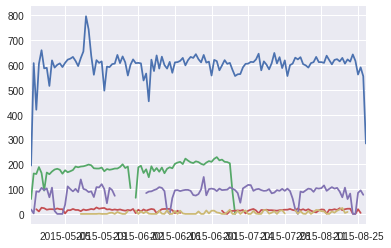

In [16]:
for rfd in wpa.raw_file_data:
    vname = rfd['village_name']
    diffed = resampled_data[vname]
    daily = diffed.groupby(diffed.index.date).sum()
    daily.plot()